In [1]:
!pip install scikeras -q

In [2]:
!pip install gensim -q

In [3]:
# Core Libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP & Text Preprocessing
import re
from bs4 import BeautifulSoup
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Word Embeddings
import gensim.downloader as api
from sklearn.base import BaseEstimator, TransformerMixin

# Scikit-learn: Data Handling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Scikit-learn: Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Scikit-learn: Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Deep Learning (Neural Networks)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from sklearn.compose import TransformedTargetRegressor

# Utilities
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Download Required Resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
!pip install kagglehub -q

In [6]:
import kagglehub

path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 11.4M/11.4M [00:00<00:00, 84.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/amananandrai/ag-news-classification-dataset/versions/2


In [7]:
import os

# List all files in the dataset folder
files = os.listdir(path)

print("Files in dataset:", files)

Files in dataset: ['test.csv', 'train.csv']


In [8]:
train_df = pd.read_csv(f'{path}/train.csv')
test_df = pd.read_csv(f'{path}/test.csv')

In [9]:
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [10]:
test_df.tail()

,Class Index,Title,Description
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...
7599,3,EBay gets into rentals,EBay plans to buy the apartment and home renta...


In [11]:
train_df['Text'] = train_df['Title'] + " " + train_df['Description']
test_df['Text'] = test_df['Title'] + " " + test_df['Description']

In [12]:
train_df['Class Index'].unique()

array([3, 4, 2, 1])

In [13]:
train_df['Class Index'].value_counts()

,count
Class Index,
3,30000
4,30000
2,30000
1,30000


In [14]:
# Clean up unused columns
train_df = train_df.drop(columns=['Title', 'Description'])

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Text         120000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [16]:
train_df.duplicated().sum()

0

In [17]:
train_df.isna().sum()

,0
Class Index,0
Text,0


In [18]:
train_df.tail()

,Class Index,Text
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...
119996,2,Renteria signing a top-shelf deal Red Sox gene...
119997,2,Saban not going to Dolphins yet The Miami Dolp...
119998,2,Today's NFL games PITTSBURGH at NY GIANTS Time...
119999,2,Nets get Carter from Raptors INDIANAPOLIS -- A...


In [19]:
# POS Mapper
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

In [20]:

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text(separator=' ')

    # Remove URLS
    text = re.sub(r'http\S+|www\S+|https\S+','',text)

    # Word Tokenization
    tokens = word_tokenize(text.lower())

    # Remove stopwords + non-alphabetic + Lemmatize with POS
    tokens = [
        lemmatizer.lemmatize(w, get_wordnet_pos(w))
        for w in tokens if w.isalpha() and w not in stop_words
        ]
    return tokens
train_df['cleaned_text'] = train_df['Text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['Text'].apply(preprocess_text)

In [21]:
train_df.head()

,Class Index,Text,cleaned_text
0,3,Wall St. Bears Claw Back Into the Black (Reute...,"[wall, bear, claw, back, black, reuters, reute..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,"[carlyle, look, toward, commercial, aerospace,..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[oil, economy, cloud, stock, outlook, reuters,..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,"[iraq, halt, oil, export, main, southern, pipe..."
4,3,"Oil prices soar to all-time record, posing new...","[oil, price, soar, record, pose, new, menace, ..."


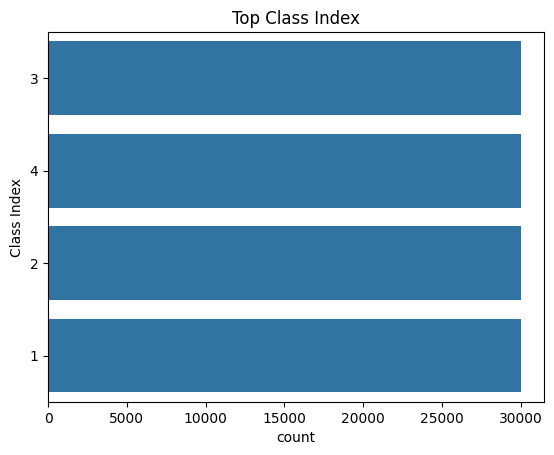

In [22]:
if 'Class Index' in train_df.columns:
    sns.countplot(data=train_df, y='Class Index', order=train_df['Class Index'].value_counts().index)
    plt.title('Top Class Index')

    # ✅ Save as image
    plt.savefig('top_class_index.png', dpi=300, bbox_inches='tight')
    plt.show()

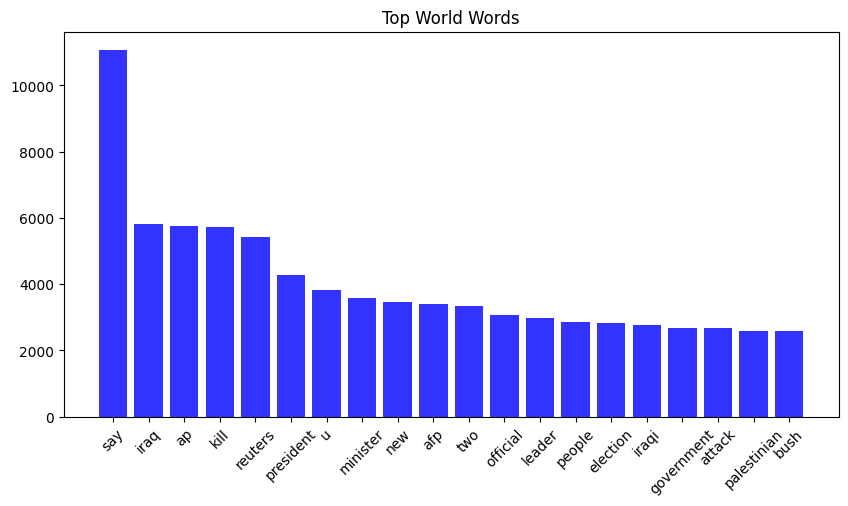

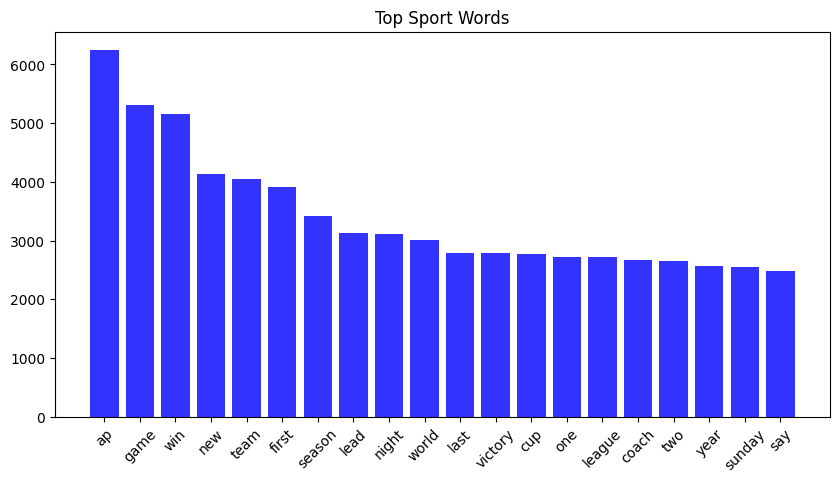

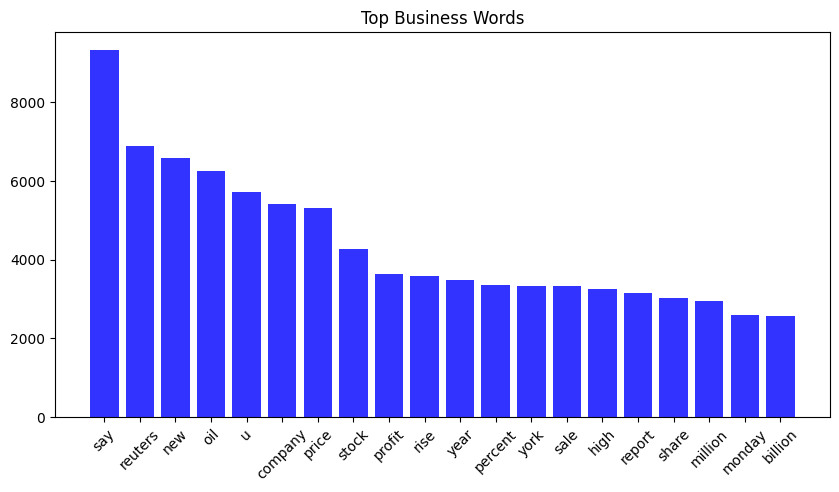

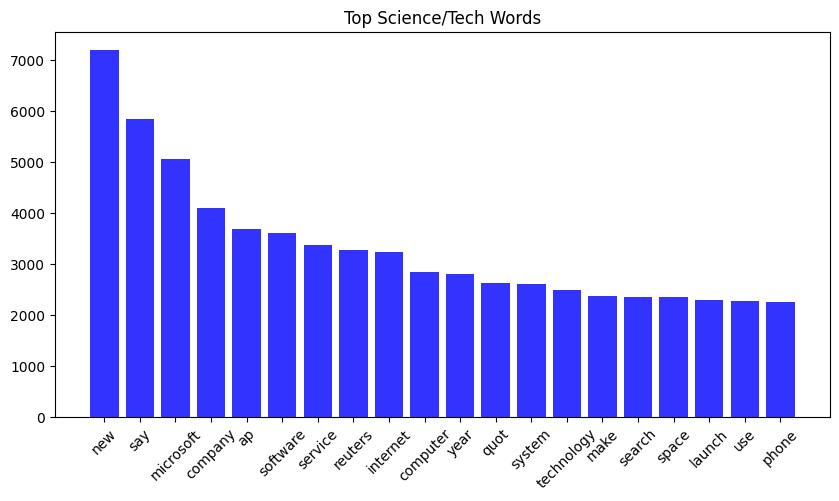

In [23]:
# Visualize the most frequent words per category using bar plots
world = ' '.join([' '.join(doc) for doc in train_df[train_df['Class Index']==1]['cleaned_text']])
sport = ' '.join([' '.join(doc) for doc in train_df[train_df['Class Index']==2]['cleaned_text']])
business = ' '.join([' '.join(doc) for doc in train_df[train_df['Class Index']==3]['cleaned_text']])
science = ' '.join([' '.join(doc) for doc in train_df[train_df['Class Index']==4]['cleaned_text']])

def most_common_words(text, title, n, filename):
    if not text:
        print(f'No words found for {title}')
        return

    words = text.split()  # Split the text into words
    counter = Counter(words)
    common = counter.most_common(n) # Get the top n most common words

    if not common:
        print(f'No words found for {title}')
        return

    words, counts = zip(*common)
    plt.figure(figsize=(10,5))
    plt.bar(words, counts, color='#33f')
    plt.title(title)
    plt.xticks(rotation=45)

    # ✅ Save as image
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

most_common_words(world, 'Top World Words', 20, 'top_world_words.png')
most_common_words(sport, 'Top Sport Words', 20, 'top_sport_words.png')
most_common_words(business, 'Top Business Words', 20, 'top_business_words.png')
most_common_words(science, 'Top Science/Tech Words', 20, 'top_science_words')

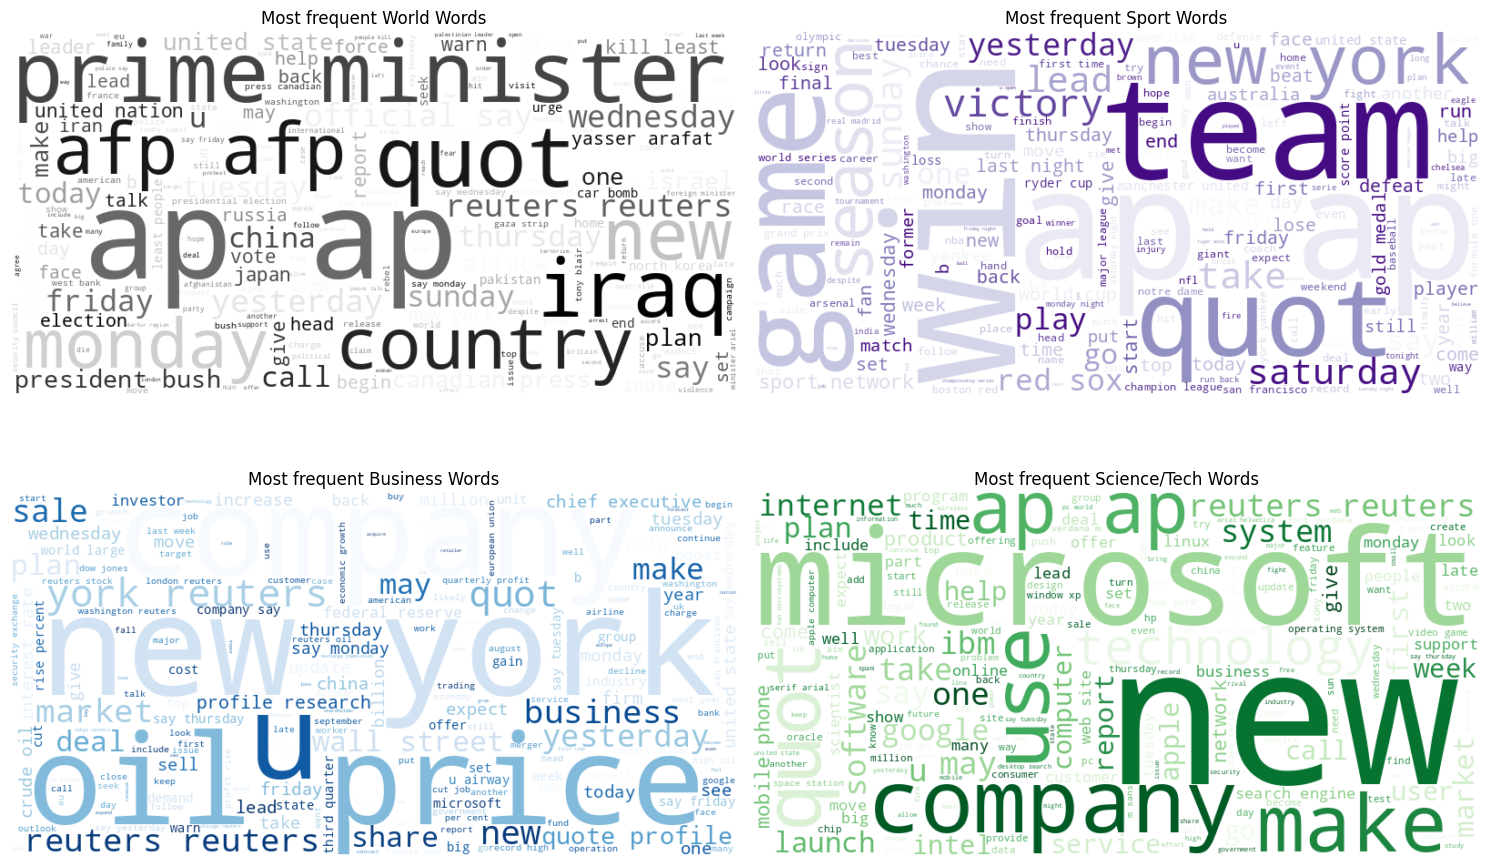

In [24]:
# Visualize the most frequent words per category using word clouds
world_WordCloud = WordCloud(width=800, height=400, background_color='white', colormap='Greys').generate(world)
sport_WordCloud = WordCloud(width=800, height=400, background_color='white', colormap='Purples').generate(sport)
business_WordCloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(business)
science_WordCloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(science)

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.imshow(world_WordCloud, interpolation='bilinear')
plt.title('Most frequent World Words')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(sport_WordCloud, interpolation='bilinear')
plt.title('Most frequent Sport Words')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(business_WordCloud, interpolation='bilinear')
plt.title('Most frequent Business Words')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(science_WordCloud, interpolation='bilinear')
plt.title('Most frequent Science/Tech Words')
plt.axis('off')

plt.tight_layout()

# ✅ Save as image
plt.savefig('word_cloud.png', dpi=300, bbox_inches='tight')

plt.show()

In [25]:
data = train_df.copy()
data.shape

(120000, 3)

In [26]:
# Uses a pre-trained word embedding model (e.g., GloVe, Word2Vec).
class EmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.dim = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vectors = []
        for doc in X:
            # Filter out words not in embeddings
            vecs = [self.model[word] for word in doc if word in self.model]
            if vecs:
                vectors.append(np.mean(vecs, axis=0))
            else:
                vectors.append(np.zeros(self.dim))
        return np.array(vectors)


In [27]:
# Define Keras Feedforward NN
def create_ffnn(input_dim, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
# Load pre-trained GloVe embeddings
glove_vectors = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [29]:
# Features and labels for training
X_train = train_df['cleaned_text']
y_train = train_df['Class Index'] - 1 # Adjust labels to be zero-indexed
y_train_encoded = to_categorical(y_train, num_classes=len(set(train_df['Class Index'])))

# Features and labels for testing
X_test = test_df['cleaned_text']
y_test = test_df['Class Index'] - 1 # Adjust labels to be zero-indexed
y_test_encoded = to_categorical(y_test, num_classes=len(set(test_df['Class Index'])))

# Build Pipelines with Multiple Models
models = {
    'Logistic Regression': LogisticRegression(solver='saga', max_iter=1000, random_state=23),
    'SVM': LinearSVC(random_state=23),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=23),
    'XGBoost': XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric="mlogloss", random_state=23),
    'Feedforward NN': TransformedTargetRegressor(
        regressor=KerasClassifier(
            model=create_ffnn,
            model__input_dim=glove_vectors.vector_size,
            model__num_classes=len(set(y_train)),
            epochs=10,
            batch_size=16,
            verbose=2
        ),
        transformer=None
    )
}

result = {}
pipelines = {}

for name, regressor in models.items():
    pipeline = Pipeline([
        ('embeddings', EmbeddingVectorizer(glove_vectors)),
        ('regressor', regressor)
    ])

    # Train and evaluate the model
    if name == 'Feedforward NN':
        pipeline.fit(X_train, y_train_encoded)
        y_pred = pipeline.predict(X_test)

        # Convert predictions back to integer labels for evaluation metrics
        y_pred = np.argmax(y_pred, axis=1)
    else:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    result[name] = accuracy
    pipelines[name] = pipeline

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    print(f'Classification Report\n {classification_report(y_test, y_pred)}\n')

Model: Logistic Regression
Accuracy: 0.8806578947368421
Classification Report
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1900
           1       0.95      0.96      0.95      1900
           2       0.83      0.83      0.83      1900
           3       0.86      0.84      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600


Model: SVM
Accuracy: 0.8821052631578947
Classification Report
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1900
           1       0.95      0.96      0.95      1900
           2       0.83      0.83      0.83      1900
           3       0.85      0.84      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.8

In [30]:
# Find the best model
best_model = max(result, key=result.get)
best_accuracy = result[best_model]
best_pipeline = pipelines[best_model]
print(f'The best model is {best_model}, with an accuracy of {best_accuracy}')

The best model is Feedforward NN, with an accuracy of 0.9032894736842105


475/475 - 1s - 1ms/step


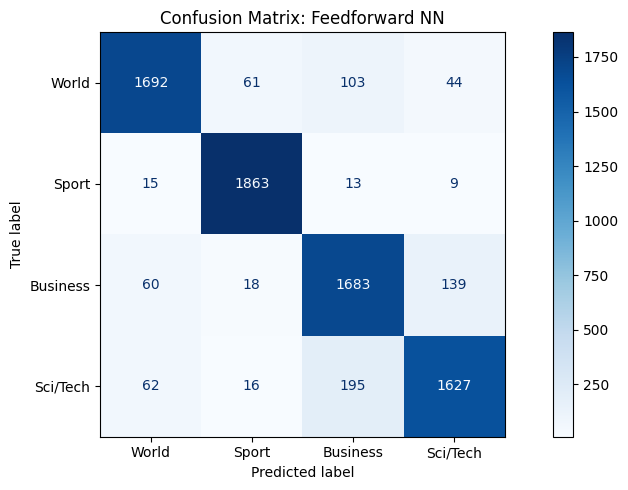

In [31]:
# Predictions with best model
y_pred_best = best_pipeline.predict(X_test)

# Convert one-hot encoded predictions back to integer labels
y_pred_best_labels = np.argmax(y_pred_best, axis=1)

# Confusion Matrix for the best model
fig, ax = plt.subplots(figsize=(10,5))
cm = confusion_matrix(y_test, y_pred_best_labels)
ConfusionMatrixDisplay(cm, display_labels=['World', 'Sport', 'Business', 'Sci/Tech']).plot(cmap='Blues', ax=ax)
plt.title(f'Confusion Matrix: {best_model}')
plt.tight_layout()

# ✅ Save as image
plt.savefig(f'confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

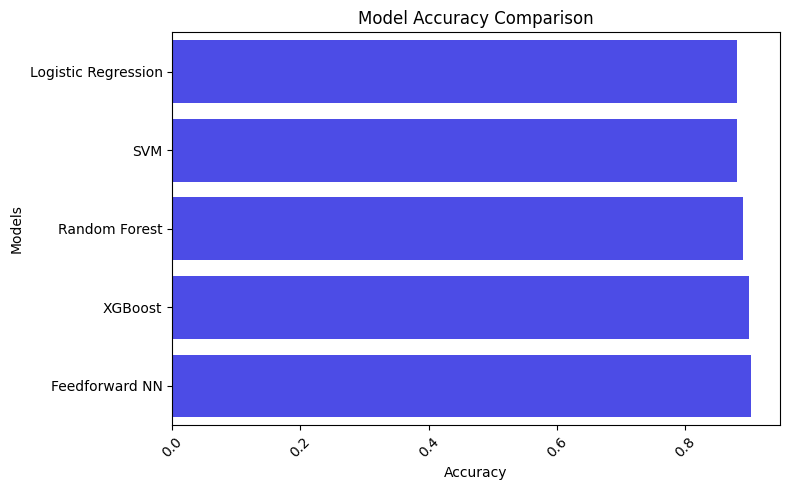

In [32]:
# Compare Model Accuracies
plt.figure(figsize=(8,5))
sns.barplot(x=result.values(), y=result.keys(), color='#33f')
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.xticks(rotation=45)
plt.title('Model Accuracy Comparison')
plt.tight_layout()

# ✅ Save as image
plt.savefig('compare_model_accuracy.png', dpi=300, bbox_inches='tight')

plt.show()

In [33]:
# Predict on New Reviews
sample_reviews=[
    'United Nations launches new climate initiative to help small island nations adapt to sea level rise.',
    'Tech giant announces $5 billion investment in renewable energy sector to cut emissions by 2030.',
    'Olympic champion wins gold again in the 100m dash, setting a new personal best.',
    'UN calls for immediate ceasefire amid rising global tensions.'
]

sample_cleaned = [preprocess_text(text) for text in sample_reviews]

best_model = Pipeline([
    ('embeddings', EmbeddingVectorizer(glove_vectors)),
    ('regressor', TransformedTargetRegressor(
        regressor=KerasClassifier(
            model=create_ffnn,
            model__input_dim=glove_vectors.vector_size,
            model__num_classes=len(set(y_train)),
            epochs=10,
            batch_size=16,
            verbose=2
        ),
        transformer=None
    ))
])
best_model.fit(X_train, y_train_encoded)

# Predict
preds = best_model.predict(sample_cleaned)
preds = np.argmax(preds, axis=1)

# Label map
label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Science/Tech'
}

for i, (j, k) in enumerate(zip(sample_cleaned, preds)):
    print(f'\n{i}. Review: {j}\nPredicted Score: {label_map[k]}')

Epoch 1/10
7500/7500 - 18s - 2ms/step - accuracy: 0.8795 - loss: 0.3513
Epoch 2/10
7500/7500 - 19s - 3ms/step - accuracy: 0.8910 - loss: 0.3159
Epoch 3/10
7500/7500 - 17s - 2ms/step - accuracy: 0.8948 - loss: 0.3039
Epoch 4/10
7500/7500 - 17s - 2ms/step - accuracy: 0.8973 - loss: 0.2967
Epoch 5/10
7500/7500 - 20s - 3ms/step - accuracy: 0.8999 - loss: 0.2895
Epoch 6/10
7500/7500 - 18s - 2ms/step - accuracy: 0.9009 - loss: 0.2841
Epoch 7/10
7500/7500 - 18s - 2ms/step - accuracy: 0.9026 - loss: 0.2804
Epoch 8/10
7500/7500 - 21s - 3ms/step - accuracy: 0.9036 - loss: 0.2765
Epoch 9/10
7500/7500 - 18s - 2ms/step - accuracy: 0.9055 - loss: 0.2720
Epoch 10/10
7500/7500 - 17s - 2ms/step - accuracy: 0.9058 - loss: 0.2711
1/1 - 0s - 72ms/step

0. Review: ['united', 'nation', 'launch', 'new', 'climate', 'initiative', 'help', 'small', 'island', 'nation', 'adapt', 'sea', 'level', 'rise']
Predicted Score: Science/Tech

1. Review: ['tech', 'giant', 'announces', 'billion', 'investment', 'renewable', 'e

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
# Save the model after training
from joblib import dump
dump(pipeline, 'model.joblib')

print('✅ Pipeline trained and saved as model.joblib')

✅ Pipeline trained and saved as model.joblib


In [37]:
!cp model.joblib /content/drive/MyDrive/Models/News-Category-Classification

In [38]:
# Confirm it has been saved
!ls /content/drive/MyDrive/Models/News-Category-Classification | grep news_model